In [44]:
import pandas
import torch
from torch import optim
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import re
from collections import Counter
from random import uniform
from pathlib import Path

gen = torch.Generator().manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def filter_dataset(dataset):
    # I may have filtered too hard
    # I removed everything between braces because that's just LateX I tried using regex but couldn't get it to work
    # Then I removed empty lines and lines that don't start with an upper case (removing this results in a bunch of random letters in th
    filtered_dataset = dataset
    # print(f'The dataset is size {len(filtered_dataset)} without filtering')
    # with open('latex.txt', 'w') as w: # use this to test wether it removes too much or too little
    #     w.write(''.join(re.findall(r' {6}\n {8}.*?(?:\\displaystyle|\\textstyle).*?\n', filtered_dataset, flags=re.DOTALL)))
    filtered_dataset = re.sub(r' {8}.*?(?:\\displaystyle|\\textstyle).*?\n', '', filtered_dataset, flags=re.DOTALL) # We lowercase the d
    # print(f'The dataset is size {len(filtered_dataset)} without the LaTeX')
    # print(f"There are currently {len(re.findall(r'displaystyle', filtered_dataset))} LaTeX blocks that have to be manually deleted")
    # filtered_dataset = '\n'.join([line for line in filtered_dataset.splitlines() if line.strip()]) #  and line[0].isupper() and len(li
    # print(len(filter_dataset))
    filtered_dataset = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)', '', filtered_dataset, re.DOTALL)
    # print(f'The dataset is size {len(filtered_dataset)} without the links')
    # I found the regex above here https://regexr.com/37i6s
    return filtered_dataset

In [62]:
def load_datasets(dataset_path: Path, sep='__WIKI__', force_filter=False):
    """Load multiple datasets located in a single file and separated by sep"""
    filtered_dataset_path = dataset_path.parent/Path('filtered_' + dataset_path.name)
    if filtered_dataset_path.exists() and not force_filter:
        return open('filtered_'+(str(name)), 'r').read()
    wikis = open(dataset_path, 'r').read().split('__WIKI__')
    wikis = [filter_dataset(wiki) for wiki in wikis]
    with open(filtered_dataset_path, 'w') as o:
        o.write('\n'.join(wikis))
    return wikis

In [74]:
def load_dataset(dataset_path, force_filter=False):
    filtered_dataset_path = dataset_path.parent/Path('filtered_' + dataset_path.name)
    if filtered_dataset_path.exists() and not force_filter:
        return open(filtered_dataset_path).read()
    dataset = open(dataset_path, 'r').read()
    filtered_dataset = filter_dataset(dataset)
    with open(filtered_dataset_path, 'w') as o:
        o.write(filtered_dataset)
    print(f'filtered {len(dataset)-len(filtered_dataset)} bytes')
    return filtered_dataset

In [75]:
dataset_path = Path('data/shakespear.txt')
dataset = load_dataset(dataset_path,force_filter=True)

filtered 0 bytes


In [76]:
class Skipgram(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_norm=1):
        super(Skipgram, self).__init__()
        self.embed = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            max_norm=max_norm
        )
        self.linear = nn.Linear(in_features=embedding_dim, out_features=vocab_size)
    def forward(self, inputs):
        return self.linear(self.embed(inputs))

In [87]:
word_tokenize = RegexpTokenizer(r'\w+').tokenize
tokenized_dataset = word_tokenize(dataset.lower())

In [80]:
# tokenized_dataset = [[[word.lower() for word in sent] for sent in wiki] for wiki in tokenized_dataset]
# I should probably do this earlier but as of now I am not sure where

In [90]:
len(tokenized_dataset)

208530

In [94]:
word2id = {}
idx = 0
for word in tokenized_dataset:
    if word not in word2id:
        word2id[word] = idx
        idx += 1
id2word = {word2id[word]: word for word in word2id}

In [95]:
word2id

{'first': 0,
 'citizen': 1,
 'before': 2,
 'we': 3,
 'proceed': 4,
 'any': 5,
 'further': 6,
 'hear': 7,
 'me': 8,
 'speak': 9,
 'all': 10,
 'you': 11,
 'are': 12,
 'resolved': 13,
 'rather': 14,
 'to': 15,
 'die': 16,
 'than': 17,
 'famish': 18,
 'know': 19,
 'caius': 20,
 'marcius': 21,
 'is': 22,
 'chief': 23,
 'enemy': 24,
 'the': 25,
 'people': 26,
 't': 27,
 'let': 28,
 'us': 29,
 'kill': 30,
 'him': 31,
 'and': 32,
 'll': 33,
 'have': 34,
 'corn': 35,
 'at': 36,
 'our': 37,
 'own': 38,
 'price': 39,
 'a': 40,
 'verdict': 41,
 'no': 42,
 'more': 43,
 'talking': 44,
 'on': 45,
 'it': 46,
 'be': 47,
 'done': 48,
 'away': 49,
 'second': 50,
 'one': 51,
 'word': 52,
 'good': 53,
 'citizens': 54,
 'accounted': 55,
 'poor': 56,
 'patricians': 57,
 'what': 58,
 'authority': 59,
 'surfeits': 60,
 'would': 61,
 'relieve': 62,
 'if': 63,
 'they': 64,
 'yield': 65,
 'but': 66,
 'superfluity': 67,
 'while': 68,
 'were': 69,
 'wholesome': 70,
 'might': 71,
 'guess': 72,
 'relieved': 73,
 'hum

In [96]:
def t(ids):
    return ' '.join([id2word[i] for i in ids])

In [13]:
# ids = [[[word2id[word] for word in sent] for sent in wiki] for wiki in tokenized_dataset]

In [14]:
sents = [sent for wiki in ids for sent in wiki]

In [15]:
len([word for word in sent for sent in sents])

64997

In [16]:
t(sents[0])

'machine learning ml is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data and thus perform tasks without explicit instructions'

In [17]:
freq = Counter([word for sent in sents for word in sent])

In [18]:
def create_training_data(sent, freq, k, t=1):
    data = []
    n = len(sent)
    for i in range(n):
        word = sent[i]
        j = i - 1
        while (i - j) <= k and j >= 0:
            # if uniform(0, 1) > (1 - (t/freq[word])): # This function is taken from the second paper by Mikolov et al.
            # It's defined in 2.3 Subsampling of Frequent Words.
            data.append((word, sent[j]))
            j -= 1
        j = i + 1
        while (j - i) <= k and j < n:
            # if uniform(0, 1) > (1 - (t/freq[word])):
            data.append((word, sent[j]))
            j += 1
    return data
    
def create_training_dataset(sents, freq, k=3):
    training_dataset = []
    
    for sent in sents:
        data = create_training_data(sent, freq, k)

        training_dataset.extend(data)

    return torch.tensor(training_dataset)


In [19]:
training_dataset = create_training_dataset(sents, freq)

In [20]:
loader = DataLoader(training_dataset, batch_size=64, shuffle=True, generator=gen, num_workers=4, pin_memory=True)

In [106]:
def train_skipgram(model, loader): # R is the range from which we take the training samples
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.03)
    loss_fn = nn.CrossEntropyLoss()
    for data in loader:
        optimizer.zero_grad()
        X = data[:, 0].to(device)
        y = data[:, 1].to(device)
        # print(X.device, y.device)
        preds = model(X)
        loss = loss_fn(preds, F.one_hot(y, num_classes=model.embed.num_embeddings).type(torch.float32))
        loss.backward()
        optimizer.step()

In [107]:
model = Skipgram(vocab_size, 60, max_norm=10)
model.to(device)
train_skipgram(model, loader)

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [23]:
torch.save(model.state_dict(), 'models/small-30-model.pt')

In [25]:
model = Skipgram(vocab_size, 30, max_norm=1)
model.load_state_dict(torch.load('models/small-30-model.pt', weights_only=True))

<All keys matched successfully>

In [39]:
def find_closest(target, model, word2id, id2word, top_k=20):
    target_idx = word2id[target]
    target_embed = model.embed(torch.tensor([target_idx]))  # Shape (1, embedding_dim)
    
    # Get all embeddings at once
    all_embeds = model.embed.weight  # Shape (num_embeddings, embedding_dim)
    
    # Compute cosine similarities between target and all other embeddings
    similarities = F.cosine_similarity(target_embed, all_embeds, dim=1)  # Shape (num_embeddings,)
    
    # Set similarity of the target word to a very low value to exclude it from results
    similarities[target_idx] = -float('inf')
    
    # Get the top K most similar embeddings
    top_k_indices = torch.topk(similarities, top_k).indices  # Shape (top_k,)
    
    # Retrieve corresponding words and similarities
    closest_words = [(similarities[i].item(), id2word[int(i)]) for i in top_k_indices]
    
    return closest_words

In [40]:
find_closest('machine', model, word2id, id2word)

tensor([11974,  3711,  5051, 29563, 37884, 35877,  2887, 38473, 26527, 16551,
        41362, 20832,  4761, 11796, 25737, 40110,  7786,  8397,  5660, 33736])


[(0.6942992806434631, 'statuses'),
 (0.6485686898231506, 'implications'),
 (0.6448972225189209, 'fails'),
 (0.6447001099586487, 'maría'),
 (0.6339156627655029, '1080084533'),
 (0.6226114630699158, 'lakatosian'),
 (0.6175073385238647, 'inaccuracy'),
 (0.6163429617881775, 'lambert'),
 (0.6010804176330566, 'reside'),
 (0.5994629859924316, 'capone'),
 (0.5873067378997803, '41180'),
 (0.5868861079216003, 'gotten'),
 (0.5863617062568665, 'sdc'),
 (0.5831090211868286, '347'),
 (0.5826400518417358, '0509'),
 (0.578592836856842, 'ti2'),
 (0.5779350399971008, 'conceivable'),
 (0.5768417716026306, 'stood'),
 (0.5760422945022583, 'logs'),
 (0.5738480091094971, 'theorypages')]

/home/me/micromamba/envs/torch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


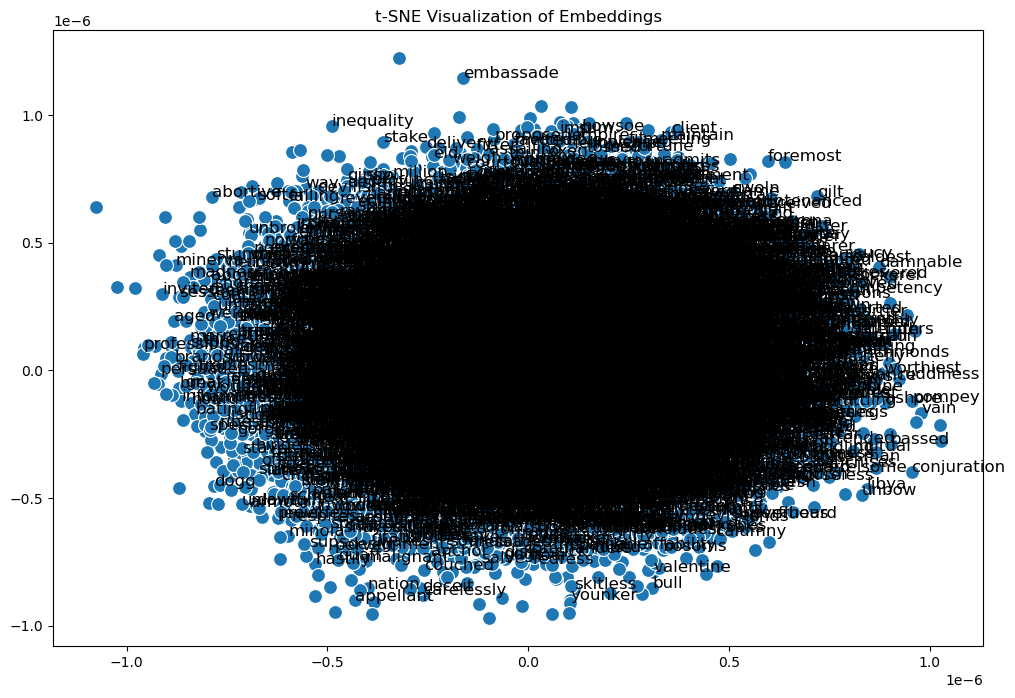

In [101]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns

@torch.no_grad()
def visualize_embeddings(embeddings, labels, perplexity=30, learning_rate=200, n_iter=1000):
    # Initialize t-SNE with desired parameters
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
    
    # Reduce dimensions to 2D
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], s=100)
    
    # Annotate points with their labels
    for i, label in enumerate(labels):
        plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=12)
    
    plt.title('t-SNE Visualization of Embeddings')
    plt.show()
visualize_embeddings(model.embed.weight, [word for word in word2id])